# Grand Total Time Series

- In this notebook I will be creating a model that predicts that the number of grand total registered voters for the State of Colorado and forecasting out roughly a year in time as well.

In [79]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

First I will try and predict registration changes over the data that I already have. I will be doing this using some Time Series techniques and a simple Gradient Boosting Regressor to see if it is possible to predict the changes in voter registration rates. This is not my untimite goal with modeling but I wanted to see if it could be done and it way give me some insight when I start to forecast. 

In [164]:
df = pd.read_csv("./Data/registration_totals_and_changes.csv")

In [165]:
# getting the columns I need
df = df[['Date', 'County', 'Year', 'Month', 'Label','Grand Total_change']]

In [166]:
df.head()

,Date,County,Year,Month,Label,Grand Total_change
0,2012-11-28,Yuma,2012,nov,REP,NaN
1,2012-11-28,La Plata,2012,nov,DEM,NaN
2,2012-11-28,Lake,2012,nov,DEM,NaN
3,2012-11-28,Larimer,2012,nov,DEM,NaN
4,2012-11-28,Las Animas,2012,nov,Swing,NaN


In [168]:
df["Odd_year"] = df["Year"] % 2
df["Odd_year"] = df["Odd_year"].apply(str)
df["Drop_month"] = df["Odd_year"] + df["Month"]
df["Drop_month"] = df["Drop_month"].map(lambda x: 1 if x == "0dec" or x == "1jan" or x == "1feb" else 0)
df["Election_buzz"] = df["Odd_year"] + df["Month"]
df["Election_buzz"] = df["Election_buzz"].map(lambda x: 1 if x == "0aug" or x == "0sept" or x == "0oct" else 0)

In [169]:
df.head()

,Date,County,Year,Month,Label,Grand Total_change,Odd_year,Drop_month,Election_buzz
0,2012-11-28,Yuma,2012,nov,REP,NaN,0,0,0
1,2012-11-28,La Plata,2012,nov,DEM,NaN,0,0,0
2,2012-11-28,Lake,2012,nov,DEM,NaN,0,0,0
3,2012-11-28,Larimer,2012,nov,DEM,NaN,0,0,0
4,2012-11-28,Las Animas,2012,nov,Swing,NaN,0,0,0


Now to create each counties Time Series Data Frame to train on. 

In [198]:
def get_time_series(df):
    grand_total_ts = pd.DataFrame()
    counties = df["County"].unique()
    for count in counties:
        county = df[df["County"] == count].copy()
        county.set_index("Date", inplace=True)
        constants = county[["County", "Year", "Month", "Label", "Odd_year", "Drop_month", "Election_buzz"]]
        totals = pd.DataFrame(county['Grand Total_change'])
        totals["Grand Total_change"] = totals["Grand Total_change"].rolling(3).mean()
        for i in range(1,4):
            month = pd.DataFrame(totals['Grand Total_change'].shift(i))
            month.columns = [col + "- " + str(i) for col in month.columns]
            totals = pd.concat([month, totals], axis=1)
        county_ts = pd.concat([constants, totals], axis=1)
        grand_total_ts = pd.concat([grand_total_ts, county_ts])
    
    return grand_total_ts

    

In [199]:
grand_total_ts = get_time_series(df)

In [200]:
grand_total_ts.dropna(inplace=True)

In [201]:
grand_total_ts.columns

Index(['County', 'Year', 'Month', 'Label', 'Odd_year', 'Drop_month',
       'Election_buzz', 'Grand Total_change- 3', 'Grand Total_change- 2',
       'Grand Total_change- 1', 'Grand Total_change'],
      dtype='object')

In [216]:
X= grand_total_ts[["Odd_year", 'Drop_month','Election_buzz', 'Grand Total_change- 3',
       'Grand Total_change- 2', 'Grand Total_change- 1']]
y= grand_total_ts["Grand Total_change"]

In [244]:
gbr = GradientBoostingRegressor(n_estimators=200)

In [245]:
cross_val_score(gbr,X,y)

array([0.74654471, 0.71231933, 0.7510823 ])

In [246]:
pred = cross_val_predict(gbr,X,y)

In [247]:
grand_total_ts_pred = pd.concat([grand_total_ts, pd.DataFrame(pred, columns=['Pred'], index=grand_total_ts.index)], axis=1)

In [248]:
#grand_total_ts_pred.to_csv("grand_total_ts_pred.csv")

# Forecasting 

The goal of this model is forecast out total voter registration out at least a year. I am going to use a seasonal ARIMA model for this forecasting because of the seasonal trends that this data contains. At first I tried to forecast out 24 months, which is one season in this data, but, after about 17 months some of the data went erratic. It would predict a smaller county to have gained 4 million voters or have negative voters. I decided to stop my forecasting at 17 months for this reason. 

In [2]:
df_f = pd.read_csv("./Data/registration_totals_and_changes.csv")

In [3]:
# getting the columns I need
df_f = df_f[['Date', 'County', 'Year', 'Month', 'Label','Grand Total']]

In [4]:
df_f.set_index("Date", inplace=True)

In [5]:
df_f["Odd_year"] = df_f["Year"] % 2
df_f["Odd_year"] = df_f["Odd_year"].apply(str)
df_f["Drop_month"] = df_f["Odd_year"] + df_f["Month"]
df_f["Drop_month"] = df_f["Drop_month"].map(lambda x: 1 if x == "0dec" or x == "1jan" or x == "1feb" else 0)
df_f["Election_buzz"] = df_f["Odd_year"] + df_f["Month"]
df_f["Election_buzz"] = df_f["Election_buzz"].map(lambda x: 1 if x == "0aug" or x == "0sept" or x == "0oct" else 0)
df_f["Odd_year"] = df_f["Odd_year"].apply(int)

In [126]:
# to test this out I am going to just use Denver county.
county = df_f[df_f["County"] == "Denver"]

In [127]:
exog = county[["Odd_year","Drop_month", "Election_buzz"]]
#"Drop_month", "Election_buzz"

In [128]:
# this sections of dates will follow the same pattern that I am going to forcast on.
exog_p = exog["2013-11-28":"2015-10-28"]

In [130]:
county_f = county["Grand Total"]

In [212]:
p = [0,1,2,3]
d = [0,1,2]
q = [0,1]

In [213]:
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [214]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(county_f,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:828.5562335262334
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:228.10134657274304
ARIMA(0, 0, 0)x(2, 0, 0, 24) - AIC:218.2084994300039
ARIMA(0, 0, 1)x(0, 0, 0, 24) - AIC:1637.4941834390793
ARIMA(0, 0, 1)x(0, 1, 0, 24) - AIC:769.0802690640348
ARIMA(0, 0, 1)x(0, 2, 0, 24) - AIC:243.85788308741834
ARIMA(0, 0, 1)x(1, 0, 0, 24) - AIC:1009.3345453760687
ARIMA(0, 0, 1)x(1, 1, 0, 24) - AIC:268.92100062415926
ARIMA(0, 0, 1)x(2, 0, 0, 24) - AIC:342.4158856668583
ARIMA(0, 1, 0)x(1, 0, 0, 24) - AIC:751.851064079422
ARIMA(0, 1, 0)x(1, 1, 0, 24) - AIC:194.1193913486374
ARIMA(0, 1, 0)x(2, 0, 0, 24) - AIC:188.8816902477986
ARIMA(0, 1, 1)x(0, 0, 0, 24) - AIC:1196.1165777778992
ARIMA(0, 1, 1)x(0, 1, 0, 24) - AIC:730.3777366948052
ARIMA(0, 1, 1)x(0, 2, 0, 24) - AIC:216.8762404243708
ARIMA(0, 1, 1)x(1, 0, 0, 24) - AIC:757.534131518371
ARIMA(0, 1, 1)x(1, 1, 0, 24) - AIC:227.5696290184142
ARIMA(0, 1, 1)x(2, 0, 0, 24) - AIC:227.49404996703043
ARIMA(0, 2, 0)x(1, 0, 0, 24) - AIC:747.40

I thought running a grid search for this for every county would be to tasking on my computer. I picked a few counties and looked for the top four lowest AIC's them compaired them to eachother. 


From looking at ARIMA models in different blogs and videos AIC(Akaike Information Critera) is the prefered way judge a ARIMA Model. But after looking at the results in Tableau I decided that AIC might not be the best was for me to judge my model. I decided to to a little experimenting and use what I know about ARIMA models to get the best forecast. I know because of my large season and small data set I could not go past one season. I also know that I wanted at least one in the middle or integrated column. That led me to test the AR and MA spots in the model. After some time testing and looking at the results in Tableau I was able to find variables that I liked. 

In [215]:
mod = sm.tsa.statespace.SARIMAX(county_f.values, exog=exog.values, order=(3, 1, 0), seasonal_order=(1, 1, 0, 24), trend="n",time_varying_regression=True,mle_regression=False)
#exog=exog.values
res = mod.fit()

print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1979          0       -inf      0.000      -0.198      -0.198
ar.L2         -0.0939          0       -inf      0.000      -0.094      -0.094
ar.L3         -0.0201          0       -inf      0.000      -0.020      -0.020
ar.S.L24      -0.8863          0       -inf      0.000      -0.886      -0.886
var.x1         0.0027   3.59e+05   7.45e-09      1.000   -7.04e+05    7.04e+05
var.x2         0.0015   9.06e+05    1.7e-09      1.000   -1.78e+06    1.78e+06
var.x3         0.0856   1.35e+06   6.35e-08      1.000   -2.64e+06    2.64e+06
sigma2       1.33e+07   1.44e+06      9.234      0.000    1.05e+07    1.61e+07


In [216]:
res.forecast(24,exog=exog_p)

array([453320.87037643, 455139.66056126, 456356.68199683, 457847.19054713,
       460067.21384212, 461988.93556   , 462802.3944671 , 465081.87821046,
       468163.82817298, 472762.43975913, 478603.55439104, 486415.35816889,
       489924.64015794, 490642.05076292, 467815.95236186, 448271.6193019 ,
       448569.0919796 , 449392.72673813, 450439.26265107, 451532.11135993,
       452621.96139855, 453610.85620579, 454294.55301985, 455086.2019625 ])

In [217]:
future = res.forecast(24,exog=exog_p)

In [218]:
start = datetime.strptime("2017-11-28", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list)
future["Forecast"] = res.forecast(24,exog=exog_p)
county_fv = pd.concat([county_f, future])

In [219]:
county_name = county["County"].unique()

In [220]:
county_name

array(['Denver'], dtype=object)

In [221]:
county_label = county["Label"].unique()

In [222]:
county_fv["County"] = county_name[0]

In [223]:
county_fv["Label"] = county_label[0]

In [224]:
county_fv.rename(columns={0:"Grand_total"}, inplace=True)

In [225]:
print(county_fv.head())
county_fv.tail()

            Grand_total  Forecast  County Label
2012-11-28     484521.0       NaN  Denver   DEM
2012-12-28     484722.0       NaN  Denver   DEM
2013-01-28     451481.0       NaN  Denver   DEM
2013-02-28     451579.0       NaN  Denver   DEM
2013-03-28     451693.0       NaN  Denver   DEM


,Grand_total,Forecast,County,Label
2019-06-28 00:00:00,NaN,451532.111360,Denver,DEM
2019-07-28 00:00:00,NaN,452621.961399,Denver,DEM
2019-08-28 00:00:00,NaN,453610.856206,Denver,DEM
2019-09-28 00:00:00,NaN,454294.553020,Denver,DEM
2019-10-28 00:00:00,NaN,455086.201962,Denver,DEM


This is the graph for Denver County.

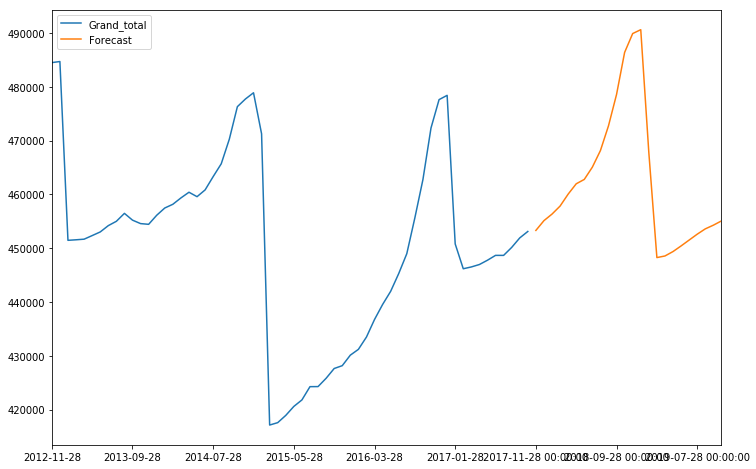

In [226]:
county_fv[["Grand_total", 'Forecast']].plot(figsize=(12, 8)) 

Below is a model to forecast on every county in Colorado. 

In [266]:
def get_total_forecast(file_path): #"./Data/registration_totals_and_changes.csv"
    df_f = pd.read_csv(file_path)
    county_forecasts = pd.DataFrame()
    
    df_f = df_f[['Date', 'County', 'Year', 'Month', 'Label','Grand Total']]
    df_f.set_index("Date", inplace=True)
    df_f["Odd_year"] = df_f["Year"] % 2
    df_f["Odd_year"] = df_f["Odd_year"].apply(str)
    df_f["Drop_month"] = df_f["Odd_year"] + df_f["Month"]
    df_f["Drop_month"] = df_f["Drop_month"].map(lambda x: 1 if x == "0dec" or x == "1jan" or x == "1feb" else 0)
    df_f["Election_buzz"] = df_f["Odd_year"] + df_f["Month"]
    df_f["Election_buzz"] = df_f["Election_buzz"].map(lambda x: 1 if x == "0aug" or x == "0sept" or x == "0oct" else 0)
    df_f["Odd_year"] = df_f["Odd_year"].apply(int)
    
    
    for count in df_f["County"].unique():
        county = df_f[df_f["County"] == count]
        exog_ts = county[["Odd_year","Drop_month", "Election_buzz"]]
        exog_p = exog_ts["2013-11-28":"2015-03-28"]
        county_f = county["Grand Total"]
#        print(count)
        mod = sm.tsa.statespace.SARIMAX(county_f.values, exog=exog_ts.values, order=(3, 1, 0), seasonal_order=(1, 1, 0, 24),
                                        trend="n", time_varying_regression=True, mle_regression=False, enforce_stationarity=False)
        res = mod.fit()
        
        start = datetime.strptime("2017-11-28", "%Y-%m-%d")
        date_list = [start + relativedelta(months=x) for x in range(0,17)]
        future = pd.DataFrame(index=date_list)
        future["Forecast"] = res.forecast(17,exog=exog_p)
        county_fv = pd.concat([county_f, future])
        
        county_name = county["County"].unique()
        county_label = county["Label"].unique()
        county_fv["County"] = county_name[0]
        county_fv["Label"] = county_label[0]
        county_fv.rename(columns={0:"Grand_total"}, inplace=True)
        county_forecasts = pd.concat([county_forecasts, county_fv])
        
    return county_forecasts


In [267]:
county_total_forecasts = get_total_forecast("./Data/registration_totals_and_changes.csv")

In [269]:
#county_total_forecasts.to_csv("county_total_forecasts.csv")

In [268]:
county_total_forecasts

,Grand_total,Forecast,County,Label
2012-11-28,6396.0,NaN,Yuma,REP
2012-12-28,6327.0,NaN,Yuma,REP
2013-01-28,6322.0,NaN,Yuma,REP
2013-02-28,6331.0,NaN,Yuma,REP
2013-03-28,6340.0,NaN,Yuma,REP
2013-04-28,6348.0,NaN,Yuma,REP
2013-05-28,6355.0,NaN,Yuma,REP
2013-06-28,6366.0,NaN,Yuma,REP
2013-07-28,6365.0,NaN,Yuma,REP
2013-08-28,6371.0,NaN,Yuma,REP
